# Doing the class 6 exp SRS in python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
import pandas as pd

import scipy.interpolate as interp
%matplotlib inline

In [2]:
# Colormap selection
xr.set_options(cmap_divergent='bwr', cmap_sequential='turbo')

In [3]:
mfdataDIR1 = 'data/GPM/2009/3B-MO.MS.MRG.3IMERG.*.V06B.HDF5.SUB.nc4'
mfdataDIR2 = 'data/GPM/2019/3B-MO.MS.MRG.3IMERG.*.V06B.HDF5.SUB.nc4'

ds1 = xr.open_mfdataset(mfdataDIR1, parallel=True)
ds2 = xr.open_mfdataset(mfdataDIR2, parallel=True)

## 2009

In [5]:
ds1

<xarray.Dataset>
Dimensions:        (lat: 1800, lon: 3600, time: 12)
Coordinates:
  * time           (time) datetime64[ns] 2009-01-01 2009-02-01 ... 2009-12-01
  * lon            (lon) float32 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
  * lat            (lat) float32 -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
Data variables:
    precipitation  (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
Attributes:
    CDI:                                    Climate Data Interface version 1....
    Conventions:                            CF-1.6
    Original_Producer_Metadata_FileHeader:  DOI=10.5067/GPM/IMERG/3B-MONTH/06...
    Original_Producer_Metadata_FileInfo:    DataFormatVersion=6a;\nTKCodeBuil...
    Original_Producer_Metadata_GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegis...
    InputPointer:                           3B-MO.MS.MRG.3IMERG.20090101-S000...
    history_L34RS:                          'Created by L34RS v1.4.2 @ NASA G...
    CDO:                                    Climate Data Operators version 1....

In [6]:
# make preciptation rate to preciptation

def convert_to_precipitaion(ds):
    temp = ds * 24
#     temp = temp.to_dataset()
    return temp

In [7]:
ds1 = convert_to_precipitaion(ds1)

In [8]:
# Transpose the data to get lat first and lon after - 

ds1 = ds1.transpose("time", "lat", "lon")

In [9]:
ds1_ind = ds1.sel(lat=slice(7,36), lon=slice(67,98)).dropna("time")

In [10]:
# Wrap it into a simple function
def season_mean(ds, calendar='standard'):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby('time.season').sum(dim='time')

In [11]:
# Get seasonal mean

ds1_ind_sm = season_mean(ds1_ind)

ds1_ind_sm

<xarray.Dataset>
Dimensions:        (lat: 290, lon: 310, season: 4)
Coordinates:
  * lon            (lon) float32 67.05 67.15 67.25 67.35 ... 97.75 97.85 97.95
  * lat            (lat) float32 7.05 7.15 7.25 7.35 ... 35.65 35.75 35.85 35.95
  * season         (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    precipitation  (season, lat, lon) float64 dask.array<chunksize=(1, 290, 310), meta=np.ndarray>

In [12]:
# Convert to dataarray

da1 = ds1_ind_sm.precipitation
da1

<xarray.DataArray 'precipitation' (season: 4, lat: 290, lon: 310)>
dask.array<concatenate, shape=(4, 290, 310), dtype=float64, chunksize=(1, 290, 310), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 67.05 67.15 67.25 67.35 ... 97.65 97.75 97.85 97.95
  * lat      (lat) float32 7.05 7.15 7.25 7.35 7.45 ... 35.65 35.75 35.85 35.95
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

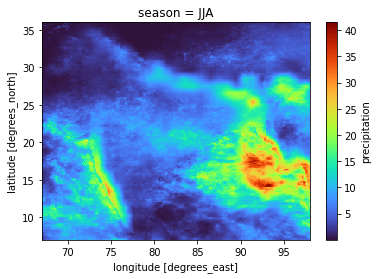

In [13]:
da1.sel(season = 'JJA').plot()

### Attempting to mask the data

In [14]:
import geopandas as gpd
from rasterio import features
from affine import Affine

def transform_from_latlon(lat, lon):
    """ input 1D array of lat / lon and output an Affine transformation
    """
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='lat', longitude='lon',
              fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.

    usage:
    -----
    1. read shapefile to geopandas.GeoDataFrame
          `states = gpd.read_file(shp_dir+shp_file)`
    2. encode the different shapefiles that capture those lat-lons as different
        numbers i.e. 0.0, 1.0 ... and otherwise np.nan
          `shapes = (zip(states.geometry, range(len(states))))`
    3. Assign this to a new coord in your original xarray.DataArray
          `ds['states'] = rasterize(shapes, ds.coords, longitude='X', latitude='Y')`

    arguments:
    ---------
    : **kwargs (dict): passed to `rasterio.rasterize` function

    attrs:
    -----
    :transform (affine.Affine): how to translate from latlon to ...?
    :raster (numpy.ndarray): use rasterio.features.rasterize fill the values
      outside the .shp file with np.nan
    :spatial_coords (dict): dictionary of {"X":xr.DataArray, "Y":xr.DataArray()}
      with "X", "Y" as keys, and xr.DataArray as values

    returns:
    -------
    :(xr.DataArray): DataArray with `values` of nan for points outside shapefile
      and coords `Y` = latitude, 'X' = longitude.


    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords['lat'], longitude: coords['lon']}
    return xr.DataArray(raster, coords=spatial_coords, dims=('lat', 'lon'))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    """ Create a new coord for the xr_da indicating whether or not it 
         is inside the shapefile

        Creates a new coord - "coord_name" which will have integer values
         used to subset xr_da for plotting / analysis/

        Usage:
        -----
        precip_da = add_shape_coord_from_data_array(precip_da, "awash.shp", "awash")
        awash_da = precip_da.where(precip_da.awash==0, other=np.nan) 
    """
    # 1. read in shapefile
    shp_gpd = gpd.read_file(shp_path)

    # 2. create a list of tuples (shapely.geometry, id)
    #    this allows for many different polygons within a .shp file (e.g. States of US)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]

    # 3. create a new coord in the xr_da which will be set to the id in `shapes`
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='longitude', latitude='latitude')

    return xr_da

In [15]:
shp_dir = './shapefiles/'

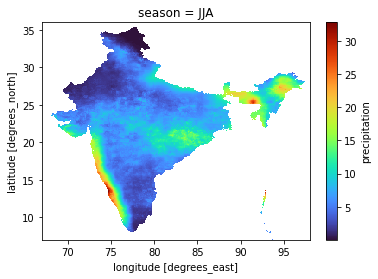

In [16]:
da1_ind = add_shape_coord_from_data_array(da1, shp_dir, "awash")
awash_da1 = da1_ind.where(da1_ind.awash==0, other=np.nan)
awash_da1.sel(season="JJA").plot()

### Take the different seasons and plot

In [17]:
awash_da1

<xarray.DataArray 'precipitation' (season: 4, lat: 290, lon: 310)>
dask.array<where, shape=(4, 290, 310), dtype=float64, chunksize=(1, 290, 310), chunktype=numpy.ndarray>
Coordinates:
  * lon        (lon) float32 67.05 67.15 67.25 67.35 ... 97.65 97.75 97.85 97.95
  * lat        (lat) float32 7.05 7.15 7.25 7.35 ... 35.65 35.75 35.85 35.95
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
    latitude   (lat) float32 7.05 7.15 7.25 7.35 ... 35.65 35.75 35.85 35.95
    longitude  (lon) float32 67.05 67.15 67.25 67.35 ... 97.65 97.75 97.85 97.95
    awash      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

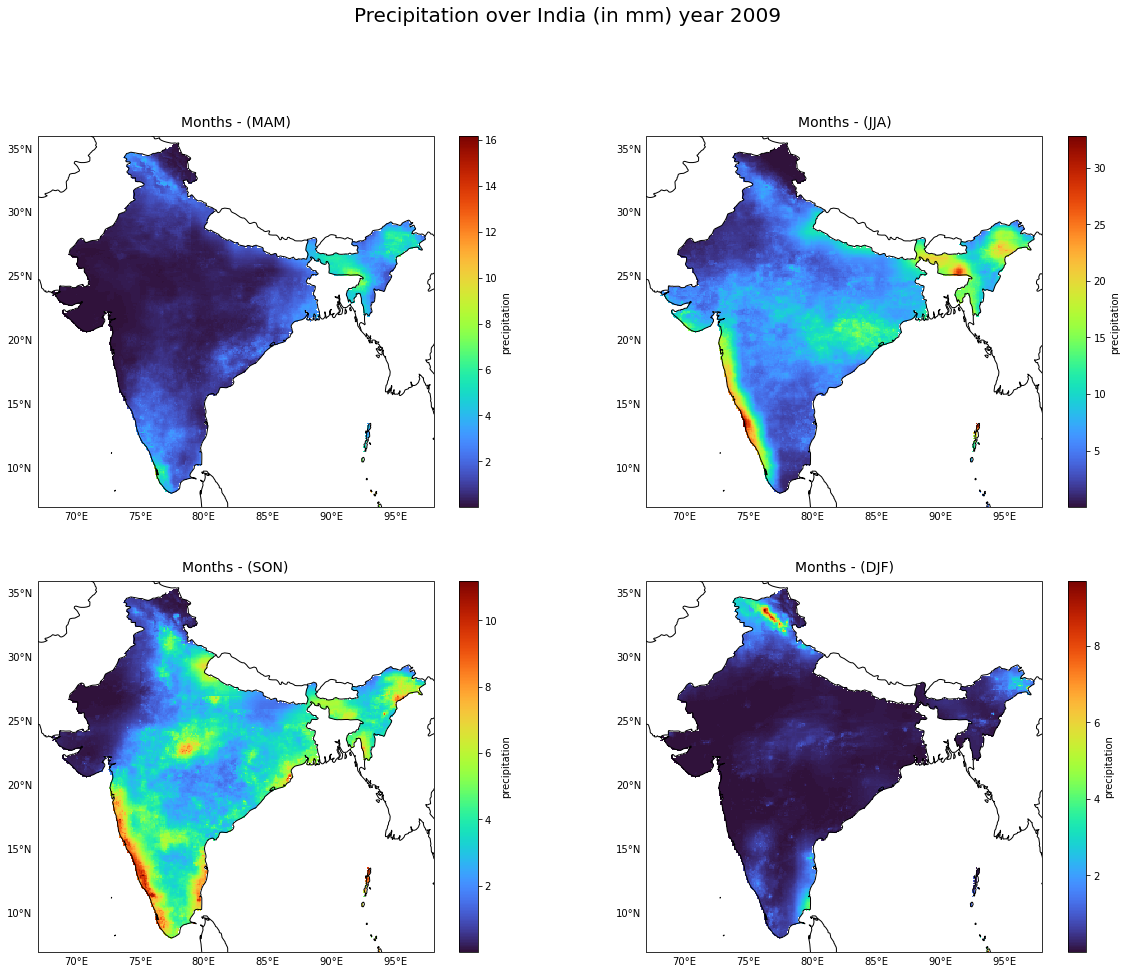

In [44]:
# Plotting

fig = plt.figure(figsize=(20, 15))
fig.tight_layout()

titles = ["MAM", "JJA", "SON", "DJF"]

for i,season in enumerate(titles):
    
    ax = fig.add_subplot(2, 2, i+1, projection=ccrs.PlateCarree())
    ax.set_extent([67, 98, 7, 36], crs=ccrs.PlateCarree())
    awash_da1.sel(season=titles[i]).plot()
    gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gridliner.top_labels = False
    gridliner.bottom_labels = True
    gridliner.left_labels = True
    gridliner.right_labels = False
    gridliner.ylines = False  # you need False
    gridliner.xlines = False  # you need False
    ax.set_title("Months"+ " " + "-" + " " + "("+titles[i]+")", pad=10, fontsize=14)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)

fig.suptitle('Precipitation over India (in mm) year 2009', fontsize=20, y=1.0)

plt.savefig('./images/GPM2009.png')

## 2019

In [22]:
ds2

<xarray.Dataset>
Dimensions:        (lat: 1800, lon: 3600, time: 12)
Coordinates:
  * time           (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2019-12-01
  * lon            (lon) float32 -179.9 -179.9 -179.8 ... 179.8 179.9 179.9
  * lat            (lat) float32 -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
Data variables:
    precipitation  (time, lon, lat) float32 dask.array<chunksize=(1, 3600, 1800), meta=np.ndarray>
Attributes:
    CDI:                                    Climate Data Interface version 1....
    Conventions:                            CF-1.6
    Original_Producer_Metadata_FileHeader:  DOI=10.5067/GPM/IMERG/3B-MONTH/06...
    Original_Producer_Metadata_FileInfo:    DataFormatVersion=6a;\nTKCodeBuil...
    Original_Producer_Metadata_GridHeader:  BinMethod=ARITHMETIC_MEAN;\nRegis...
    InputPointer:                           3B-MO.MS.MRG.3IMERG.20190101-S000...
    history_L34RS:                          'Created by L34RS v1.4.2 @ NASA G...
    CDO:                                    Climate Data Operators version 1....

In [23]:
# make preciptation rate to preciptation

ds2 = convert_to_precipitaion(ds2)

In [24]:
# Transpose the data to get lat first and lon after - 

ds2 = ds2.transpose("time", "lat", "lon")

In [29]:
ds2_ind = ds2.sel(lat=slice(7,36), lon=slice(67,98)).dropna("time")

In [30]:
# Get seasonal mean

ds2_ind_sm = season_mean(ds2_ind)

ds2_ind_sm

<xarray.Dataset>
Dimensions:        (lat: 290, lon: 310, season: 4)
Coordinates:
  * lon            (lon) float32 67.05 67.15 67.25 67.35 ... 97.75 97.85 97.95
  * lat            (lat) float32 7.05 7.15 7.25 7.35 ... 35.65 35.75 35.85 35.95
  * season         (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    precipitation  (season, lat, lon) float64 dask.array<chunksize=(1, 290, 310), meta=np.ndarray>

In [31]:
# Convert to dataarray

da2 = ds2_ind_sm.precipitation
da2

<xarray.DataArray 'precipitation' (season: 4, lat: 290, lon: 310)>
dask.array<concatenate, shape=(4, 290, 310), dtype=float64, chunksize=(1, 290, 310), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 67.05 67.15 67.25 67.35 ... 97.65 97.75 97.85 97.95
  * lat      (lat) float32 7.05 7.15 7.25 7.35 7.45 ... 35.65 35.75 35.85 35.95
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

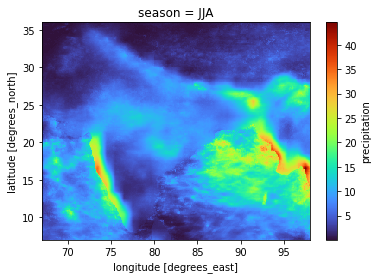

In [32]:
da2.sel(season = 'JJA').plot()

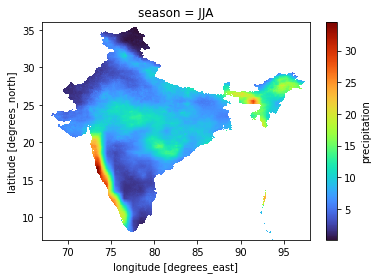

In [33]:
# Masking the data

da2_ind = add_shape_coord_from_data_array(da2, shp_dir, "awash")
awash_da2 = da2_ind.where(da2_ind.awash==0, other=np.nan)
awash_da2.sel(season="JJA").plot()

In [37]:
awash_da2

<xarray.DataArray 'precipitation' (season: 4, lat: 290, lon: 310)>
dask.array<where, shape=(4, 290, 310), dtype=float64, chunksize=(1, 290, 310), chunktype=numpy.ndarray>
Coordinates:
  * lon        (lon) float32 67.05 67.15 67.25 67.35 ... 97.65 97.75 97.85 97.95
  * lat        (lat) float32 7.05 7.15 7.25 7.35 ... 35.65 35.75 35.85 35.95
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
    latitude   (lat) float32 7.05 7.15 7.25 7.35 ... 35.65 35.75 35.85 35.95
    longitude  (lon) float32 67.05 67.15 67.25 67.35 ... 97.65 97.75 97.85 97.95
    awash      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

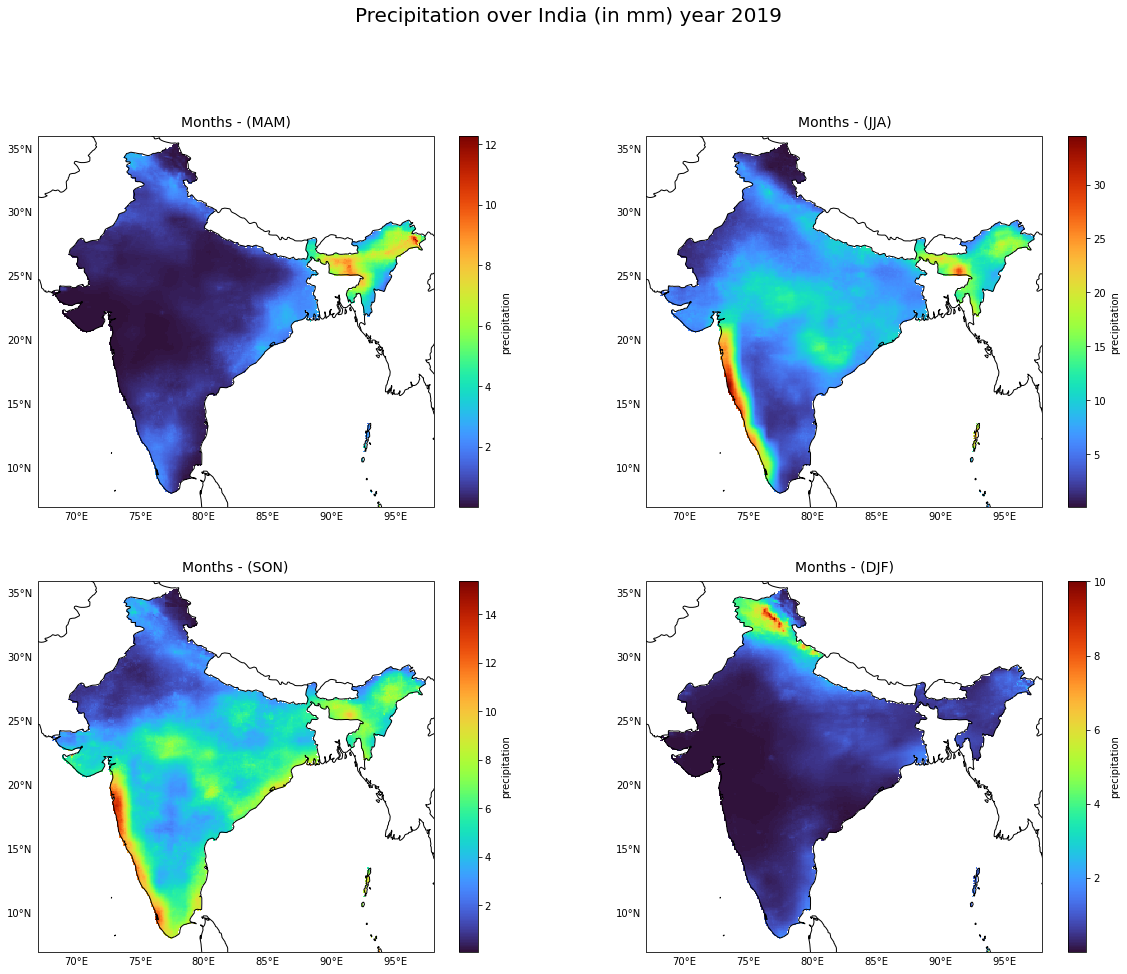

In [43]:
# Plotting

fig = plt.figure(figsize=(20, 15))
fig.tight_layout()
titles = ["MAM", "JJA", "SON", "DJF"]

for i,season in enumerate(titles):
    
    ax = fig.add_subplot(2, 2, i+1, projection=ccrs.PlateCarree())
    ax.set_extent([67, 98, 7, 36], crs=ccrs.PlateCarree())
    awash_da2.sel(season=titles[i]).plot()
    gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gridliner.top_labels = False
    gridliner.bottom_labels = True
    gridliner.left_labels = True
    gridliner.right_labels = False
    gridliner.ylines = False  # you need False
    gridliner.xlines = False  # you need False
    ax.set_title("Months"+ " " + "-" + " " + "("+titles[i]+")", pad=10, fontsize=14)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)

fig.suptitle('Precipitation over India (in mm) year 2019', fontsize=20, y=1.0)
plt.savefig('./images/GPM2019.png')

## IMD Data

In [151]:
imd_2009 = 'data/IMD/_Clim_Pred_LRF_New_RF25_IMD0p252009.nc'
imd_2019 = 'data/IMD/_Clim_Pred_LRF_New_RF25_IMD0p252019.nc'

ds3 = xr.open_dataset(imd_2009)
ds4 = xr.open_dataset(imd_2019)

In [152]:
ds3 = ds3.rename_dims({'LONGITUDE':'lon', 'LATITUDE': 'lat', 'TIME':'time'})
ds4 = ds4.rename_dims({'LONGITUDE':'lon', 'LATITUDE': 'lat', 'TIME':'time'})

In [153]:
ds3

<xarray.Dataset>
Dimensions:    (lat: 129, lon: 135, time: 365)
Coordinates:
    LONGITUDE  (lon) float64 66.5 66.75 67.0 67.25 ... 99.25 99.5 99.75 100.0
    LATITUDE   (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.75 38.0 38.25 38.5
    TIME       (time) datetime64[ns] 2009-01-01 2009-01-02 ... 2009-12-31
Dimensions without coordinates: lat, lon, time
Data variables:
    RAINFALL   (time, lat, lon) float32 ...
Attributes:
    history:      FERRET V6.9   13-Jan-21
    Conventions:  CF-1.0

In [154]:
ds3_ind_sm = ds3.groupby('TIME.season').mean(dim='time')
ds4_ind_sm = ds4.groupby('TIME.season').mean(dim='time')

ds3_ind_sm

<xarray.Dataset>
Dimensions:    (lat: 129, lon: 135, season: 4)
Coordinates:
    LONGITUDE  (lon) float64 66.5 66.75 67.0 67.25 ... 99.25 99.5 99.75 100.0
    LATITUDE   (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.75 38.0 38.25 38.5
  * season     (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: lat, lon
Data variables:
    RAINFALL   (season, lat, lon) float32 nan nan nan nan ... nan nan nan nan

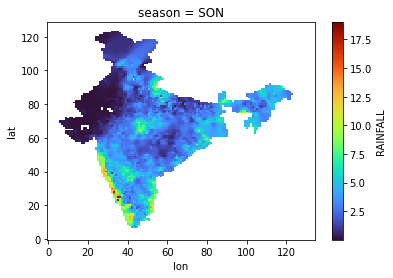

In [172]:
# Test plot

ds3_ind_sm.RAINFALL.sel(season='SON').plot()

#### Plotting imd plots

In [165]:
da3 = ds3_ind_sm.RAINFALL

AttributeError: 'AxesSubplot' object has no attribute 'add_feature'

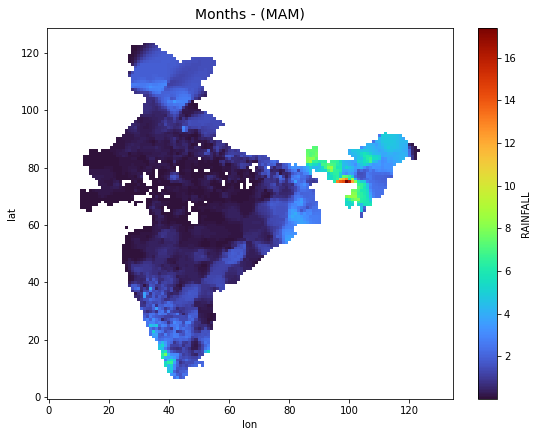

In [169]:
# Plotting

fig = plt.figure(figsize=(20, 15))
fig.tight_layout()
titles = ["MAM", "JJA", "SON", "DJF"]

for i,season in enumerate(titles):
    
    ax = fig.add_subplot(2, 2, i+1)
#     ax.set_extent([66, 100, 6, 40])
    da3.sel(season=titles[i]).plot()
#     gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gridliner.top_labels = False
    gridliner.bottom_labels = True
    gridliner.left_labels = True
    gridliner.right_labels = False
    gridliner.ylines = False  # you need False
    gridliner.xlines = False  # you need False
    ax.set_title("Months"+ " " + "-" + " " + "("+titles[i]+")", pad=10, fontsize=14)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)

fig.suptitle('IMD Data - Precipitation over India (in mm) year 2009', fontsize=20, y=1.0)
plt.savefig('./images/IMD2009.png')